# Expressibility of the alternating layered ansatz for quantum computation
Original paper by Kouhei Nakaji and Naoki Yamamoto available at [arXiv:2005.12537v2](https://arxiv.org/abs/2005.12537).

## Imports

In [1]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter

## General ansatz block

In [2]:
def block(n: int, param_prefix: str = "θ"):
    qc = QuantumCircuit(n)
    for i in range(n):
        qc.ry(Parameter(param_prefix + "_" + str(i)), i)
    for i in range(0, n-1, 2):
        qc.cx(i, i+1)
    for i in range(1, n-1, 2):
        qc.cx(i, i+1)
    qc.name = "block"
    return qc

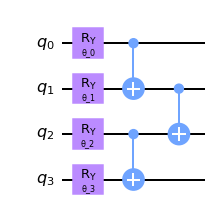

In [3]:
block(4).draw("mpl")

## Alternating layered ansatz

In [4]:
def alt(l: int, n: int, m: int):
    if m % 2 != 0:
        raise Exception("Parameter `m` must be an even number")
    if n % m != 0:
        raise Exception("Parameter `n` divided by `m` must be integer")
    
    qc = QuantumCircuit(n)
    for i in range(l):
        if (i + 1) % 2 == 0:
            qc.append(block(m//2, param_prefix=f"θ_{i}_0"), range(0, m//2))
            for j in range(m//2, n-m//2, m):
                qc.append(block(m, param_prefix=f"θ_{i}_{j}"), range(j, j+m))
            qc.append(block(m//2, param_prefix=f"θ_{i}_{j+1}"), range(n-m//2, n))
        else:
            for j in range(0, n, m):
                qc.append(block(m, param_prefix=f"θ_{i}_{j}"), range(j, j+m))
    return qc

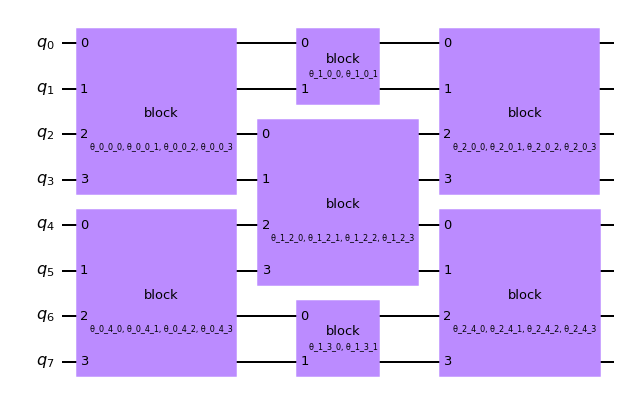

In [5]:
alt(3, 8, 4).draw("mpl")

## Tensor product ansatz

In [6]:
def ten(l: int, n: int, m: int):
    if m % 2 != 0:
        raise Exception("Parameter `m` must be an even number")
    if n % m != 0:
        raise Exception("Parameter `n` divided by `m` must be integer")
    
    qc = QuantumCircuit(n)
    for i in range(l):
        for j in range(0, n, m):
            qc.append(block(m, param_prefix=f"θ_{i}_{j}"), range(j, j+m))
    return qc

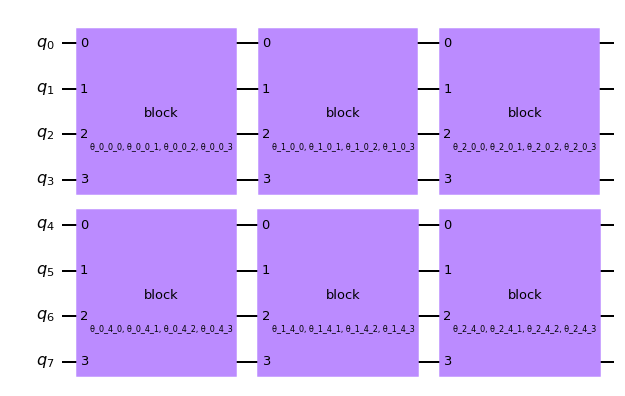

In [7]:
ten(3, 8, 4).draw("mpl")

## Testing with VQE

In [8]:
from qiskit.algorithms import VQE
from qiskit.opflow import Z, I
from qiskit.providers.basicaer import QasmSimulatorPy
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library import TwoLocal
import matplotlib.pyplot as plt

In [9]:
def test_ansatz(ansatz, num_qubits, fig_title):
    hamiltonian   = (Z ^ Z) ^ (I ^ (num_qubits - 2))
    target_energy = -1
    
    optimizer     = SPSA()
    np.random.seed(2022)
    initial_point = np.random.random(ansatz.num_parameters)
    
    intermediate_info = {"nfev": [], "parameters": [], "energy": [], "stddev": []}

    def callback(nfev, parameters, energy, stddev):
        intermediate_info["nfev"].append(nfev)
        intermediate_info["parameters"].append(parameters)
        intermediate_info["energy"].append(energy)
        intermediate_info["stddev"].append(stddev)
        
    local_vqe = VQE(
        ansatz=ansatz,
        optimizer=optimizer,
        initial_point=initial_point,
        quantum_instance=QasmSimulatorPy(),
        callback=callback,
    )
    local_result = local_vqe.compute_minimum_eigenvalue(hamiltonian)
    print("Eigenvalue:", local_result.eigenvalue)
    print("Target:", target_energy)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(intermediate_info["nfev"], intermediate_info["energy"], color="red")
    ax.set_xlabel("Optimization step", fontsize = 14)
    ax.set_ylabel("Energy", color="red", fontsize=12)
    ax2=ax.twinx()
    ax2.plot(intermediate_info["nfev"], intermediate_info["stddev"], color="blue")
    ax2.set_ylabel("Deviation",color="blue",fontsize=12)
    plt.title(fig_title)
    plt.show()

In [10]:
num_qubits = 8
layers     = 3
block_size = 2

Eigenvalue: (-1+0j)
Target: -1


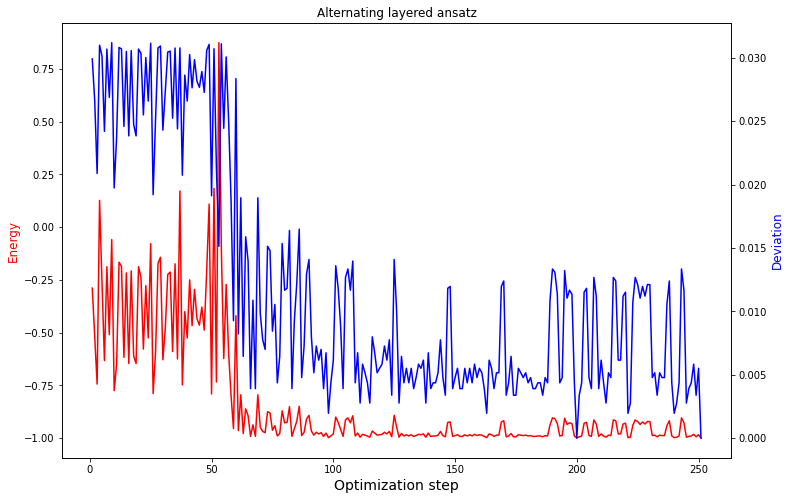

In [11]:
alt_ansatz = alt(layers, num_qubits, block_size)
test_ansatz(alt_ansatz, num_qubits, "Alternating layered ansatz")

Eigenvalue: (-1+0j)
Target: -1


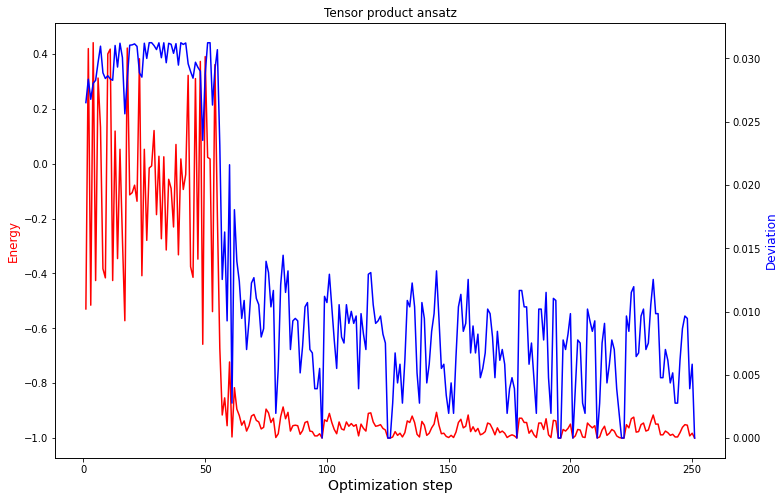

In [12]:
ten_ansatz = ten(layers, num_qubits, block_size)
test_ansatz(ten_ansatz, num_qubits, "Tensor product ansatz")

Eigenvalue: (-1+0j)
Target: -1


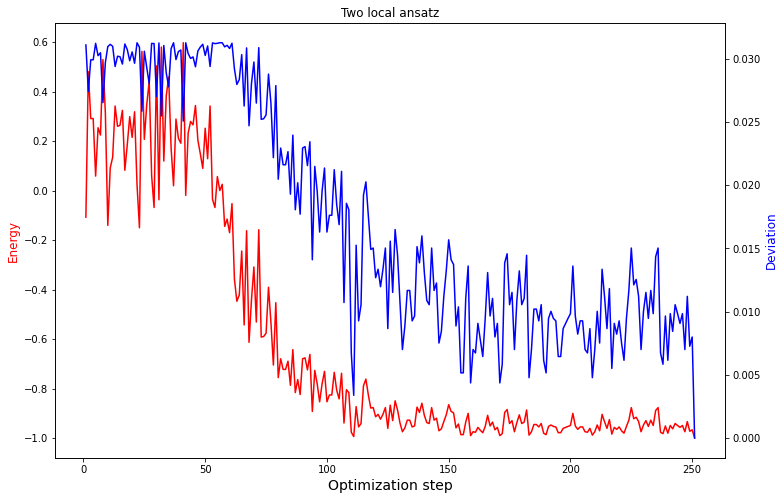

In [13]:
two_local_ansatz = TwoLocal(num_qubits, "ry", "cx", reps=layers)
test_ansatz(two_local_ansatz, num_qubits, "Two local ansatz")